In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
df = pd.read_csv('gof-motivations.csv')
print(df)

               pattern_name                                         motivation
0          abstract_factory  Consider a user interface toolkit that support...
1                   builder  A reader for the RTF (Rich Text Format) docume...
2            factory_method  Frameworks use abstract classes to define and ...
3                 prototype  You could build an editor for music scores by ...
4                 singleton  It’s important for some classes to have exactl...
5                   adapter  Sometimes a toolkit class that’s designed for ...
6                    bridge  When an abstraction can have one of several po...
7                 composite  Graphics applications like drawing editors and...
8                 decorator  Sometimes we want to add responsibilities to i...
9                    façade  Structuring a system into subsystems helps red...
10                flyweight  Some applications could benefit from using obj...
11                    proxy  One reason for controll

In [3]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in df['motivation'].tolist():
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)


vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 9757 items in vocab_frame


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['motivation'].tolist()) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 170 ms, sys: 2.98 ms, total: 173 ms
Wall time: 176 ms
(23, 121)


/Users/jonathangarelick/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [5]:
terms = tfidf_vectorizer.get_feature_names_out()


from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [6]:

from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 129 ms, sys: 37.9 ms, total: 167 ms
Wall time: 39.1 ms


In [7]:
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster1.pkl')

km = joblib.load('doc_cluster1.pkl')
clusters = km.labels_.tolist()

In [8]:
films = { 'pattern_name': df['pattern_name'].tolist(), 'motivation': df['motivation'].tolist(),'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['pattern_name', 'motivation', 'cluster'])

In [9]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


1    10
0     7
2     6
Name: cluster, dtype: int64

In [10]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d names:" % i, end='')
    for title in frame.loc[i]['pattern_name'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'instances', b'request', b'representing', b'subclasses', b'define', b'change',

Cluster 0 names: prototype, singleton, chain_of_responsibility, interpreter, mediator, state, visitor,

Cluster 1 words: b'interface', b'clients', b'implement', b'graphical', b'user', b'windows',

Cluster 1 names: abstract_factory, adapter, bridge, composite, decorator, façade, iterator, memento, observer, strategy,

Cluster 2 words: b'document', b'application', b'creating', b'request', b'text', b'subclasses',

Cluster 2 names: builder, factory_method, flyweight, proxy, command, template_method,





In [11]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [12]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'graphical, request, interface, user, drawing, editor', 
                 1: 'document, application, creating, subclasses, request, text', 
                 2: 'interface, clients, instances, define, change, abstract'}

KeyError: 'pattern_name'

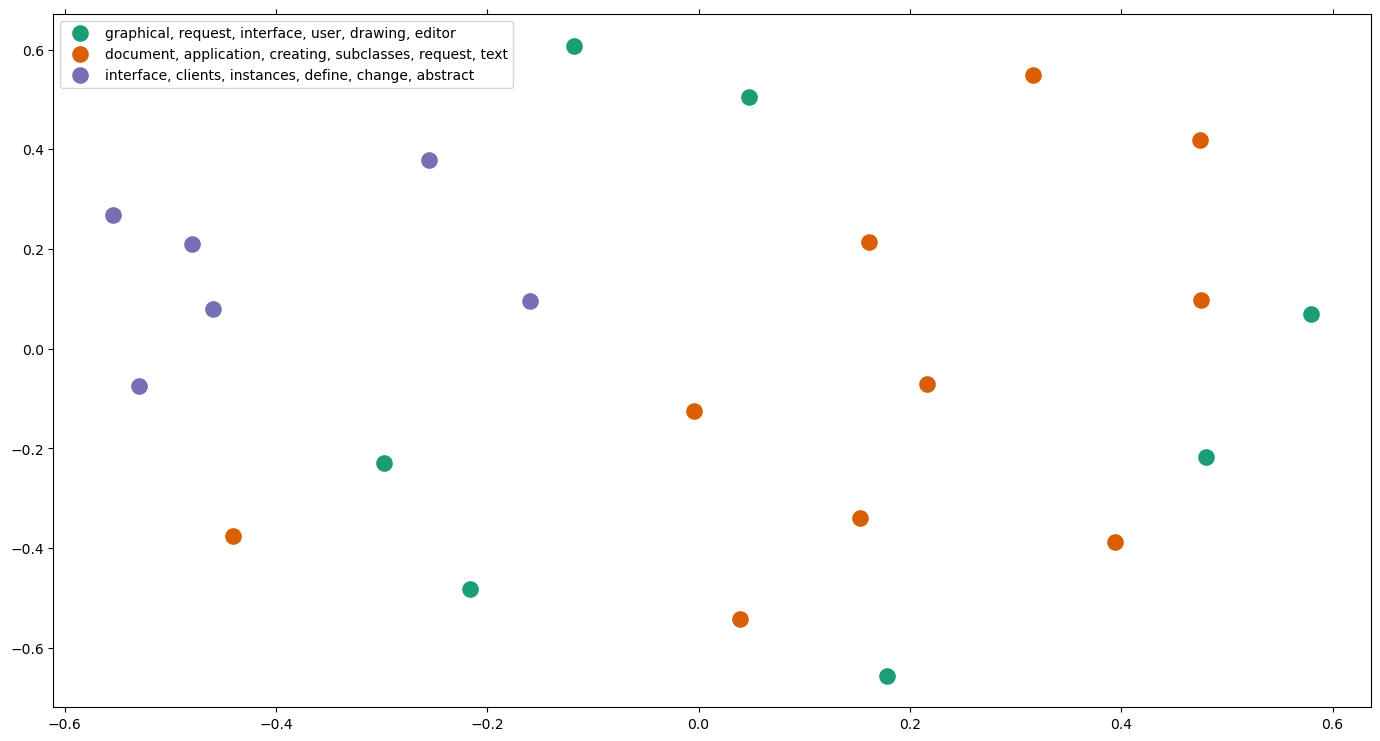

In [15]:

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df['pattern_name'].tolist())) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['pattern_name'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)